In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
#rc('text', usetex=False) # para usar latex en matplotlib
from matplotlib import animation # animaciones
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import pandas as pd

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra

# Laboratorio 3

El objetivo de este laboratorio es entender e implementar un esquema numérico basado en elementos finitos de Lagrange para una ecuacion elíptica de segundo orden en una dimensión con condiciones de frontera Dirichlet.

Sean $\alpha,\beta,u_{\alpha},u_{\beta}\in\mathbb{R}$, $\varepsilon>0$,
$\Omega=\left(  \alpha,\beta\right)  $, $a\in W^{1,\infty}\left(
\Omega\right)  $, $b\in L^{\infty}\left(  \Omega\right)  $ y $f\in
L^{2}\left(  \Omega\right)  $. 

Considere la siguiente ecuación de difusión-advección-reacción dada por
$\begin{align}
-\varepsilon u^{\prime\prime}+au^{\prime}+bu  &  =f\qquad\text{sobre }%
\Omega\nonumber\\
u\left(  \alpha\right)   &  =u_{\alpha}\tag{P}\\
u\left(  \beta\right)   &  =u_{\beta}\nonumber
\end{align}$

### **Ejercicio 1:**

Programe una funcion que resuelva numéricamente el problema (P) usando el metodo descrito. Las entradas del programa deben ser la discretización $\{x_j\}^{N+1}_{j=0}$ como un vector ordenado, $u_\alpha$,$u_\beta$, $\varepsilon$, $a$, $b$ y $f$. 

La salida de este programa debe ser un vector del mismo tamaño que la discretización con las soluciones discretas del esquema.

In [14]:
def Resuelve(x,ualpha,ubeta,eps,a,b,f):
    
    
    N = x.shape[0]-2
    h = [x[i+1]-x[i] for i in range(N+1)]
    
    s = np.array([1/hi for hi in h])
    d = np.array([1/h[0]] + [1/h[i] + 1/h[i+1] for i in range(N)] + [1/h[N]])
    
    offset = [-1,0,1]
    
    A0 = eps * diags(np.array([-s,d,-s], dtype= object), offset)
    
    s = np.ones(N+1)
    d = np.array([-1] + [0]*N + [1])
    
    A1 = (a/2) * diags(np.array([-s,d,s], dtype= object), offset) 
    
    s = np.array([hi for hi in h])
    d = np.array([h[0]] + [h[i] + h[i+1] for i in range(N)] + [h[N]])
    
    A2 = (b/6) *  diags(np.array([s,2*d,s], dtype= object), offset) 
    
    A = A0 + A1 + A2
    
    bar = lambda x, y: (x+y)/2
    
    f0 = [h[0]*(f(x[0]) + 2*f(bar(x[0], x[1])))] + [h[i+1] * (f(x[i+1]) + 2*f(bar(x[i+1], x[i+2]))) + h[i] * (f(x[i+1]) + 2*f(bar(x[i], x[i+1]))) for i in range(N)] + [h[N]*(f(x[N+1]) + 2*f(bar(x[N], x[N+1])))]
    
    f_vec = 1/6 * np.array(f0)
    
    A_star = csr_matrix(A.todense()[1:N+1,1:N+1])
    
    f_star = f_vec[1:N+1]
    
    b0 = [A.todense()[1, 0] * ualpha] + [0]*(N-2) + [A.todense()[N, N+1] * ubeta]
    b_star = f_star - np.array(b0)
    
    w_star = spsolve(A_star, b_star)
    
    u = np.array([ualpha] + list(w_star) + [ubeta])
    
    return u


### **Ejercicio 2:** 
Considere $f\equiv1$, $a=1$, $b=0$ y $\Omega=\left(  0,1\right)  $.

Para $u_{\alpha}=u_{\beta}=0$, la solución analítica de $\textbf{(P)}$ es única e igual a la
función
$$
u(x)=x-\dfrac
{\exp\left(  \frac{x-1}{\varepsilon}\right)  -\exp\left(  -\frac
{1}{\varepsilon}\right)  }{1-\exp\left(  -\frac{1}{\varepsilon}\right)}\hspace{1cm} \forall x\in\left[  0,1\right] 
$$

a. Para una discretización uniforme con $N \in \{5, 10, 20\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$), calcule la solución numérica cuando $\varepsilon = 1$. Grafique todas las soluciones numéricas y la solución analítica (esta última discretizada en una gran cantidad de puntos equiespaciados) en una misma gráfica. Comente sus observaciones.

In [89]:
#Parametros
f= lambda x: 1
a= 1
b= 0
ualpha= 0
ubeta= 0
u = {5: None, 10: None, 20: None}
x = {5: None, 10: None, 20: None}
for N in u.keys():
    h = 1/(N+1)
    eps = 1
    xN = np.array([h*k for k in range(N+2)])
    x[N] = xN
    uN = Resuelve(xN,ualpha,ubeta,eps,a,b,f)
    u[N] = uN

In [90]:
u0 = lambda x: x-(np.exp(x-1)-np.exp(-1))/(1-np.exp(-1))

In [91]:
x0 = np.linspace(0, 1, 100)
u0N =  u0(x0)

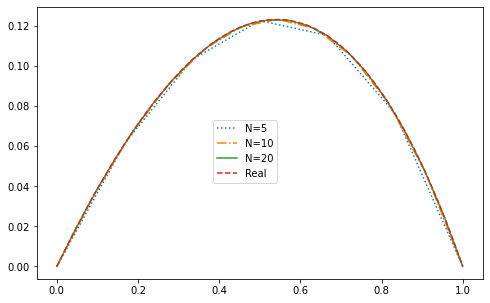

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
styles = {5: ":", 10: "-.", 20: "-"}
for N in u.keys():
    ax.plot(x[N], u[N], label=f"N={N}", linestyle=styles[N])
ax.plot(x0, u0N, label="Real", linestyle="--")
fig.legend(loc="center");
plt.title("");

**Comentarios:** A partir de N=10 se alcanza una buena solucion aproximada.

In [ ]:
# Graficos errores

b. Repita lo anterior para $\varepsilon = 10^{−j}$ , con $j \in \{1, 2, 3\}$ y $N \in \{10, 25, 50, 100, 250, 500, 1000\}$. Gráfique los tres primeros valores de $N$ en una figura, los dos siguientes en una distinta y los últimos dos en otra. 
    
Comente sus observaciones.

In [84]:
epss = {j: 10**(-j) for j in [1, 2, 3]}
Ns = [10, 25, 50, 100, 250, 500, 1000]

u = {}
x = {}
for j, eps in epss.items():
    uj = {}
    xj = {}
    for N in Ns:
        h = 1/(N+1)
        xN = np.array([h*k for k in range(N+2)])
        xj[N] = xN
        uN = Resuelve(xN,ualpha,ubeta,eps,a,b,f)
        uj[N] = uN
    u[j] = uj
    x[j] = xj

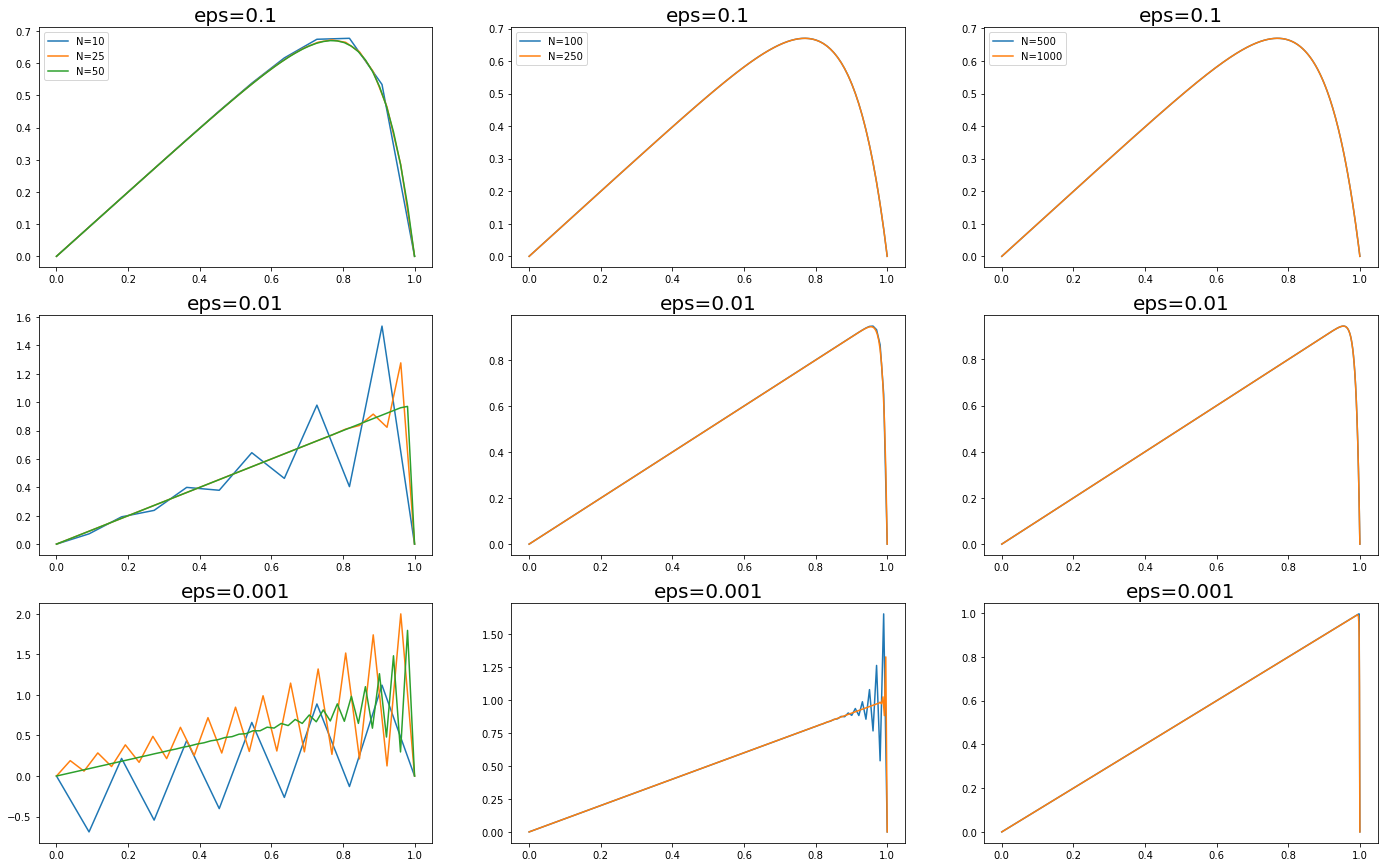

In [85]:
fig, ax = plt.subplots(3, 3, figsize=(8*3, 5*3))

for j, eps in epss.items():
    for k, A in enumerate([ [10, 25, 50] , [100, 250] , [500, 1000]]):
        for N in A:
            axk = ax[j-1, k]
            axk.plot(x[j][N], u[j][N], label=f"N={N}")
            axk.set_title(f"eps={eps}", size=20)
        if j == 1:
            axk.legend()
    

**Comentarios:** Cuando epsilon es pequeño se requiere un N mas grande para alcanzar una buena solucion aproximada. 

In [87]:
# Graficos con errores

##### Estimación del error


**Teorema:** Sean $\alpha,\beta,u_{\alpha},u_{\beta}\in\mathbb{R}$, $\varepsilon>0$,
$\Omega=\left(  \alpha,\beta\right)  $, $a\in W^{1,\infty}\left(
\Omega\right)  $, $b\in L^{\infty}\left(  \Omega\right)  $ y $f\in
L^{2}\left(  \Omega\right)  $. 
Considere $u$ y $u_{h}$ soluciones únicas de (FV) y (FVD), respectivamente. Entonces, existen constantes $C_{0}>0$ y $C_{1}>0$, independientes de $h$, tales que:
$$
\left\Vert u-u_{h}\right\Vert _{0,\Omega}\leq C_{0}h^{2}\hspace{1cm
}\left\vert u-u_{h}\right\vert _{1,\Omega}\leq C_{1}h
$$


Para hacer este cálculo de forma eficiente, se elegirá una regla de cuadratura conveniente. En primer lugar,
$$\left\Vert u-u_{h}\right\Vert _{0,\Omega}^{2}=\sum_{j=1}^{N}\int_{T_{j}%
}\left(  u\left(  x\right)  -u_{h}\right)  ^{2}\text{ }dx
$$
donde $u_{h}$ es de grado a lo más $1$. Aplicando la regla de Simpson, se
tiene que:
$$
\left\Vert u-u_{h}\right\Vert _{0,\Omega}^{2}=\sum_{j=1}^{N}\dfrac{h_{j}}{6}\left[  \left(  u\left(  x_{j}\right)  -u_{j}^{h}\right)  ^{2}+4\left(
u\left(  \bar{x}_{j}\right)  -\dfrac{u_{j}^{h}+u_{j}^{h}}{2}\right)
^{2}+\left(  u\left(  x_{j+1}\right)  -u_{j+1}^{h}\right)  ^{2}\right]
+\mathcal{O}\left(  h_{j}^{5}\right)
$$
Luego, repitiendo el mismo análisis, se tiene que:
$$
\left\vert u-u_{h}\right\vert _{1,\Omega}^{2}=\sum_{j=1}^{N}\int_{T_{j}%
}\left(  u^{\prime}\left(  x\right)  -u_{h}^{\prime}\right)  ^{2}\text{ }dx
$$
donde $u_{h}^{\prime}$ es una función constante a trozos. Entonces, aplicando
la regla del punto medio, se cumple que:
$$
\left\vert u-u_{h}\right\vert _{1,\Omega}^{2}=\sum_{j=1}^{N}h_{j}\left(
u^{\prime}\left(  \bar{x}_{j}\right)  -\dfrac{u_{j+1}-u_{j}}{h_{j}}\right)
^{2}+\mathcal{O}\left(  h_{j}^{3}\right)
$$




c. Considere ahora $\varepsilon = 0.01$ y una discretización uniforme con $N \in \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}$ elementos (es decir, $h_j = h = \frac{1}{N}$). Estime el error en las normas $L^2(\Omega)$, $H^1(\Omega)$ y en la seminorma de $H^1(\Omega)$, grafíquelos y tabúlelos en función de $h$. Para ello, cree una función que permita obtener esos errores. Dicha función debe tener como entradas la discretización del dominio, el vector solución del primer ejercicio, la solución real y su derivada. Las salidas deben ser las normas del error en los espacios $L^2(\Omega)$ y $H^1(\Omega)$, y la seminorma del error en el espacio $H^1(\Omega)$. 

Comente sus resultados.
    
**Indicación:** Puede ser útil usar escala logarítmica para la gráfica de errores. Asimismo, puede resultar útil usar curvas de la forma $Ch$ o $Ch^2$ para comparar las curvas de error con sus respectivos ordenes de convergencia.

In [98]:
def calcular_errores(eps, Ns, f):
    """Calcula el error de la solucion al problema (1) para una lista de valores de N"""
    
    return hs, error


In [ ]:
def tabulador(eps, Ns, f):
    
    return 

### **Ejercicio 3:** 
Considere $f\equiv1$, $a=0$, $b=1$ y $\Omega=\left(  0,1\right)  $.

Para $u_{\alpha}=1, u_{\beta}=0$, la solución analítica de $\textbf{(P)}$ es única e igual a la
función
$$
u(x)=1-\dfrac
{\sinh\left(\varepsilon^{\frac{-1}{2}}x\right)  }{\sinh\left(\varepsilon^{\frac{-1}{2}}\right)}\hspace{1cm} \forall x\in\left[  0,1\right] 
$$

a. Para una discretización uniforme con $N \in \{5, 10, 20, 40, 80\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$), calcule la solución numérica cuando $\varepsilon = 1$. Grafique todas las soluciones numéricas y la solución analítica (esta última discretizada en una gran cantidad de puntos equiespaciados) en una misma gráfica. Comente sus observaciones.

In [3]:
#Parametros
f=lambda x: 1
a=0
b=1
ualpha=
ubeta=

b. Repita lo anterior para $\varepsilon = 10^{−j}$ , con $j \in \{1, 2, 3\}$ y $N \in \{10, 25, 50, 100, 250, 500, 1000\}$. Gráfique los tres primeros valores de $N$ en una figura, los dos siguientes en una distinta y los últimos dos en otra. 
    
    Comente sus observaciones.

c. Considere ahora $\varepsilon = 10^{-4}$ y una discretización uniforme con $N \in \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$). Estime el error en las normas $L^2(\Omega)$, $H^1(\Omega)$ y en la seminorma de $H^1(\Omega)$, grafíquelos y tabúlelos en función de $h$. Para ello, cree una función que permita obtener esos errores. Dicha función debe tener como entradas la discretización del dominio, el vector solución del primer ejercicio, la solución real y su derivada. Las salidas deben ser las normas del error en los espacios $L^2(\Omega)$ y $H^1(\Omega)$, y la seminorma del error en el espacio $H^1(\Omega)$. 

    Comente sus resultados.
    
    **Indicación:** Puede ser útil usar escala logarítmica para la gráfica de errores. Asimismo, puede resultar útil usar curvas de la forma $Ch$ o $Ch^2$ para comparar las curvas de error con sus respectivos ordenes de convergencia.

In [4]:
def calcular_errores(eps, Ns, f):
    """Calcula el error de la solucion al problema (2) para una lista de valores de N"""
   
    
    return hs,error

In [5]:
def tabulador(eps, Ns, f):
    
    return 